# Earth Quakes

![](img/seismograph.jpg)   
$^{1}$Image credit: [Morrison1977](https://www.istockphoto.com/es/vector/sism%C3%B3grafo-terremoto-vector-de-m%C3%A1quina-gm515970956-88760147) via [iStock](https://www.istockphoto.com/es).

Mar, 2023
> *Exploratory Data Analysis, Statistics, Probability*

## Background
Watching the news about the recent terrible earthquakes in Turkey and Syria, I could not help wondering how a similar disaster would hit my town. Was to resist the building I live in under such a major quake? But the thought simply becomes unthinkable, first of all because we consider that catastrophes only happen away. And then because I live in a very stable region where there are no earthquakes.

Really?

I have never noticed any tremor myself, but I knew some little ones occur here from time to time. In fact, the Pyrenees are close by: the Iberian peninsula is pushing against Europe, and that strain is likely to cause tensions. I decided to check it out to get a sense of the seismic activity in my region.

In [43]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import geopandas as gpd
import contextily
from datetime import date, timedelta
import my_functions as my

## The data
On the [Spanish Geographic Institute](http://www.ign.es/web/resources/sismologia/tproximos/prox.html) website there is an image viewer showing the latest earthquakes.

![](img/ign.jpg)

On the same website, the [Spanish Seismic Catalogue](https://www.ign.es/web/ign/portal/sis-catalogo-terremotos) is available to download earthquake data just entering the date range and specifying the area.

I requested all registered quakes:
- In the last 100 years.
- In an area that covers the province of Gipuzkoa (lat_min = 42.89, lat_max = 43.41, lng_min = -1.72, lng_max = -2.61). This is a rectangle that catches also some territory closer to the Pyrenees (Navarre), as it can be seen in the map below.

A CSV file was produced. I downloaded it and read it as a Pandas data frame.

In [44]:
# Read the data from the file
quakes = pd.read_csv("data/quakes.csv",
                     sep=";", skipinitialspace=True, usecols=[1, 2, 3, 4, 5, 7, 9],
                     parse_dates=["Fecha"], index_col="Fecha")
print(quakes)

                Hora  Latitud  Longitud  Prof. (Km)  Mag.    Localización
Fecha                                                                    
1928-01-29  23:00:00  43.3000   -2.0000         0.0   NaN   SAN SEBASTIAN
1935-09-05  05:00:00  43.3167   -1.9833         0.0   NaN   SAN SEBASTIAN
1972-06-28  01:47:26  43.1000   -2.1000         0.0   3.0       TOLOSA.SS
1974-11-06  12:05:59  43.3100   -2.1400         0.0   3.3      NW ORIO.SS
1976-06-27  07:45:18  43.0200   -1.8600         0.0   3.5    NE MUGIRO.NA
...              ...      ...       ...         ...   ...             ...
2022-07-28  21:26:42  43.1269   -1.9935        34.0   1.8  W BERASTEGI.SS
2022-04-08  21:46:52  43.1864   -1.7589        15.0   1.5   SW ARANTZA.NA
2022-10-08  22:42:49  43.1555   -1.8948         2.0   1.6  SW GOIZUETA.NA
2022-08-31  07:36:43  43.1100   -1.8997         1.0   2.0    NE LEITZA.NA
2022-12-22  22:21:44  42.9732   -2.2350         0.0   2.1    SE SEGURA.SS

[511 rows x 6 columns]


## Data validation
From the data frame preview, I can already see that some magnitudes are missing in the column named `Mag.` (The downloaded CSV had another column containing an intensity value. The column was for the Mercalli scale, which is basically subjective. As this column had very few values, I did not use it for the project).

So the first two records (from 1928 and 1935) have no `Mag.` (magnitude) value, which is understandable since [Charles Richter](https://en.wikipedia.org/wiki/Charles_Francis_Richter) did not introduce his famous quantifying scale until 1935. Therefore, the available data spans from 1972 onwards (the last 50 years).

In [45]:
# Show information of the dataframe
quakes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 511 entries, 1928-01-29 to 2022-12-22
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Hora          511 non-null    object 
 1   Latitud       511 non-null    float64
 2   Longitud      511 non-null    float64
 3   Prof. (Km)    511 non-null    float64
 4   Mag.          506 non-null    float64
 5   Localización  511 non-null    object 
dtypes: float64(4), object(2)
memory usage: 27.9+ KB


Apart from those two first ones, only three more records have the magnitude missing, so I am going to dismiss them altogether.

In [46]:
# Remove rows with missing values in magnitude
quakes = quakes.dropna(subset=["Mag."])
quakes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 506 entries, 1972-06-28 to 2022-12-22
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Hora          506 non-null    object 
 1   Latitud       506 non-null    float64
 2   Longitud      506 non-null    float64
 3   Prof. (Km)    506 non-null    float64
 4   Mag.          506 non-null    float64
 5   Localización  506 non-null    object 
dtypes: float64(4), object(2)
memory usage: 27.7+ KB


## Exploratory analysis
First, I am going to classify earthquakes into categories according to their magnitudes:

| Magnitude     | Type | Average earthquake effects |
|----------|----------|----------|
| 0 -- 2  | micro | Microearthquakes, not felt, or felt rarely. Recorded by seismographs. |
| 2 -- 3  | minor | Felt slightly by some people. No damage to buildings.     |
| 3 -- 4  | felt | Often felt by people, but very rarely causes damage. Shaking of indoor objects can be noticeable.     |
| 4 -- 5  | light | Noticeable shaking of indoor objects and rattling noises. Felt by most people in the affected area. Slightly felt outside. Generally causes zero to minimal damage. Moderate to significant damage very unlikely. Some objects may fall off shelves or be knocked over.     |

*Note*: in the data frame there are no earthquakes above 3.9, so only the first 3 levels will be represented: `micro`, `minor` and `felt`. However, for the sake of comparison, I thought it would be useful to describe the effects of the next magnitude level called `light`.

In [47]:
# Establish category intervals according to magnitude (parenthesis right-side included)
bins = pd.IntervalIndex.from_tuples([(0, 1.9), (1.9, 2.9), (2.9, 3.9), (3.9, 4.9)])

# Define list of attributes according to the categories
scale = ["0 <   mag <  2 (micro)", "2 <= mag <  3 (minor)", "3 <= mag <  4 (felt)", "4 <= mag <  5 (light)"]
markersize = [10, 20, 30, 40]

# Create new columns in the dataframe with the scale assigned according to magnitude
quakes["scale"] = pd.cut(quakes["Mag."], bins).replace(bins, scale)
quakes["markersize"] = pd.cut(quakes["Mag."], bins).replace(bins, markersize)

Let's localize the earthquakes on a map.

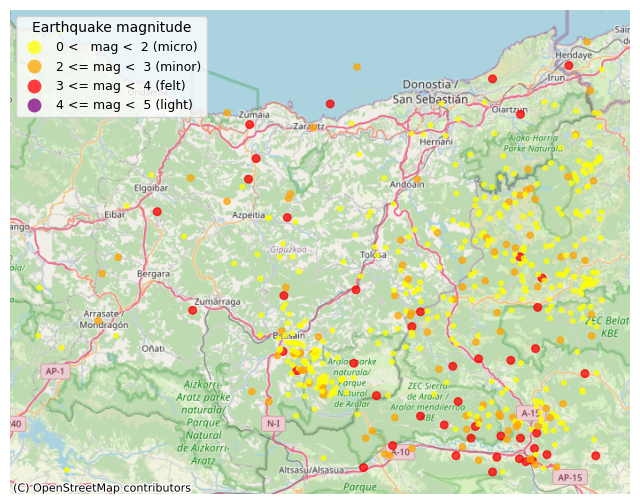

In [48]:
# Create GeoPandas dataframe
quakes_4326 = gpd.GeoDataFrame(quakes,
                              crs="EPSG:4326",
                              geometry=gpd.points_from_xy(quakes.Longitud, quakes.Latitud))

# Convert to projected reference system
quakes_3857 = quakes_4326.copy()
quakes_3857.geometry = quakes_3857.geometry.to_crs(epsg=3857)

# Plot with backgraound map
fig, ax = plt.subplots(figsize=(8, 8))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow", "orange", "red", "purple"])
legend_kwds = {'title': 'Earthquake magnitude', 'fontsize': 9, 'loc': 'upper left'}

quakes_3857.plot(ax=ax,
                 column="scale", legend=True, legend_kwds=legend_kwds,
                 cmap=cmap, markersize="markersize", alpha=0.75)

contextily.add_basemap(ax,
                       zoom=10,
                       crs="EPSG:3857",
                       source=contextily.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()

As expected, it turns out there is higher activity in areas closer to the Pyrenees (right of the map).   
(One interesting thing grabbed my attention: the concentration of points at the centre, beside the town of Beasain —which is just 15 km away from where I live. There has been quite an activity there, seemingly coming from neighbouring mountain range called Aralar. I did not know about that. I googled for information and found out that indeed these mountains are quite active due to a thrust fault located there, which reverberates with the tremors originating in the Pyrenees.)

Let's visualize the distribution of the magnitudes.

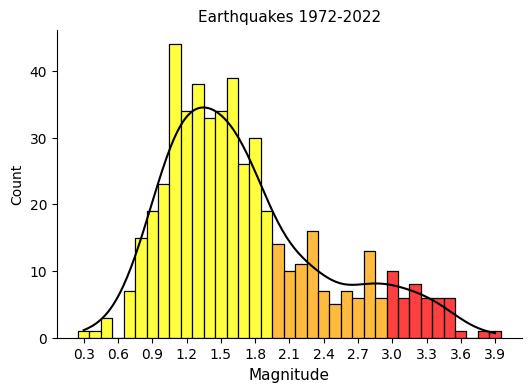

In [49]:
# Create magnitude dataframes for plotting
quakes_mag_1 = quakes[quakes["Mag."] < 2]["Mag."]
quakes_mag_2 = quakes[(quakes["Mag."] >= 2) & (quakes["Mag."] < 3)]["Mag."]
quakes_mag_3 = quakes[(quakes["Mag."] >= 3) & (quakes["Mag."] < 4)]["Mag."]

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(quakes["Mag."] * 10, ax=ax, stat="count", discrete=True,
             fill=False, kde=True, color="black")
sns.histplot(quakes_mag_1 * 10, ax=ax, stat="count", discrete=True, color="yellow")
sns.histplot(quakes_mag_2 * 10, ax=ax, stat="count", discrete=True, color="orange")
sns.histplot(quakes_mag_3 * 10, ax=ax, stat="count", discrete=True, color="red")

ax.tick_params(axis='x', labelsize=10, rotation=0)
ax.tick_params(axis='y', labelsize=10)
ax.set_title("Earthquakes 1972-2022", fontsize=11)
ax.set_xlabel("Magnitude", fontsize=11)
ax.set_ylabel("Count", fontsize=10)
ax.set_xticks(range(3, 40, 3), labels=list(np.arange(0.3, 4.0, 0.3).round(1)))
sns.despine()

plt.show()

And the evolution of them during the years.

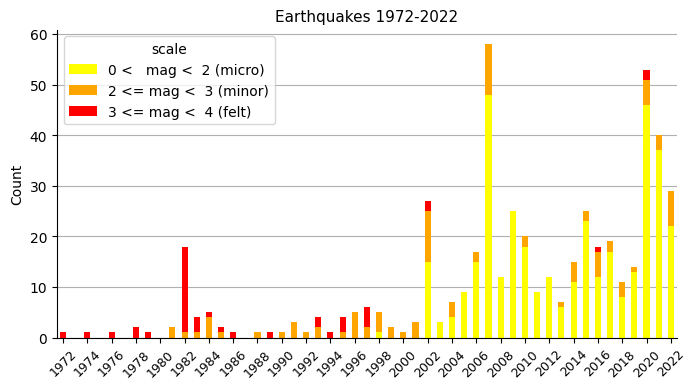

In [50]:
# Count quakes per year and per level, then unstack level to wide dataframe format
quakes_yearly = quakes.groupby([quakes.index.year, "scale"])["Mag."].count().unstack()

# Take only the represented 3 levels
quakes_yearly = quakes_yearly.iloc[:, :3]

# Create index with all years -to include years without quakes, for a comprehensive plot
new_index = list(range(1972, 2023))
quakes_yearly = quakes_yearly.reindex(new_index, fill_value=0)

# Plot stacked bar chart with appropriate colours
fig, ax = plt.subplots(figsize=(8, 4))

quakes_yearly.plot(ax=ax, kind="bar", stacked=True, color=["yellow", "orange", "red"])

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=9, rotation=45)
ax.tick_params(axis='y', labelsize=10)
ax.set_title("Earthquakes 1972-2022", fontsize=11)
ax.set_xlabel("", fontsize=11)
ax.set_ylabel("Count", fontsize=10)
ax.set_xticks(range(0, 51, 2), labels=list(range(1972, 2023, 2)))
sns.despine()

plt.show()

Looking at this plot, it seems clear that something changed around the end of the nineties: procedures changed or measurement equipment (seismographs) was renewed. Because only from 1998 onwards are micro earthquakes (yellow) registered. Also, because of the previously recorded relatively higher amount of felt quakes (red), it looks like prior measurements may not be very reliable, or at least not comparable with the ones that came after 1998.

## Seismology

### Distribution of magnitudes
The **Gutenberg-Richter law** is a general feature of earthquakes, and it states that the magnitudes of earthquakes in a given region over a given time period are Exponentially distributed, being $m'$ the rate parameter of the distribution, and:

$m' = m - m_{t}$

Where:
- $m$: the mean of the measured earthquake magnitudes.   
- $m_{t}$: *completeness threshold*. The magnitude above which we can measure all earthquakes.

The distribution previously plot did not look Exponential, but that was because low magnitude earthquakes are difficult to capture and only a fraction of them are measured. $m_{t}$, the *completeness threshold*, marks the point up from which *all* earthquakes are captured and so the distribution looks Exponential, as stated by the Gutenberg-Richter law.
 
I will select a threshold value  $m'=1.3$ to make the distribution look exponential.

In [51]:
# Define completeness threshold
mt = 1.3
print(f"Selected completeness threshold: {mt}")

# Take only measures above completeness threshold
mags = np.array(quakes["Mag."])
m = mags[mags >= mt]

# Compute optimal value of exp. distribution
m_prime = (np.mean(m) - mt)
print(f"Exponential distribution parameter: {m_prime:.2f}")

Selected completeness threshold: 1.3
Exponential distribution parameter: 0.70


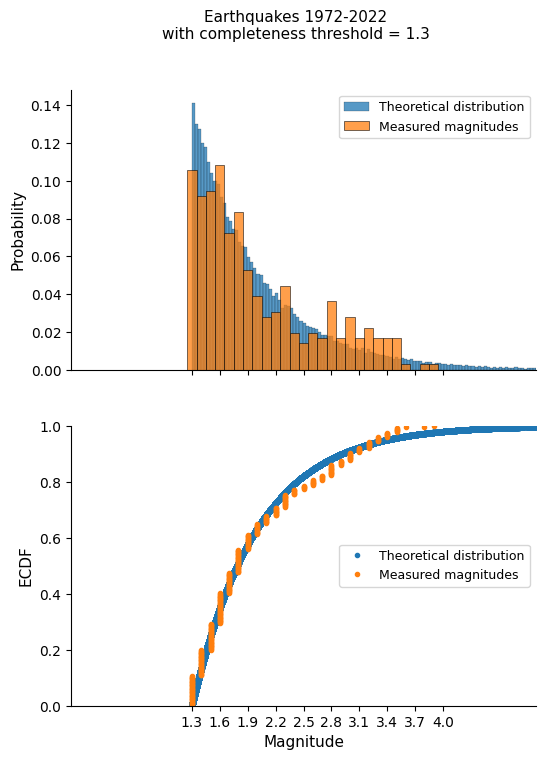

In [52]:
# Generate samples for theoretical exponential distribution
m_theor = np.random.exponential(m_prime, size=100000) + mt

# Plot
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 8))

fig.suptitle(f'Earthquakes 1972-2022\nwith completeness threshold = 1.3', fontsize=11)

sns.histplot(m_theor * 10, ax=ax[0], stat="density", label="Theoretical distribution")
sns.histplot(mags[mags >= mt] * 10, ax=ax[0], stat="density", discrete=True, label="Measured magnitudes")
sns.ecdfplot(m_theor * 10, ax=ax[1], marker='.', linestyle='none', label="Theoretical distribution")
sns.ecdfplot(mags[mags >= mt] * 10, ax=ax[1], marker='.', linestyle='none', label="Measured magnitudes")

for i in range(2):
    ax[i].tick_params(axis='x', labelsize=10, rotation=0)
    ax[i].tick_params(axis='y', labelsize=10)
    ax[i].set_xlabel("Magnitude", fontsize=11)
    ax[i].set_xticks(range(13, 41, 3), labels=list(np.arange(1.3, 4.0, 0.3).round(1)))
    ax[i].set_xlim(0, 50)
  
ax[0].set_ylabel("Probability", fontsize=11)
ax[1].set_ylabel("ECDF", fontsize=11)
ax[0].legend(loc='upper right', fontsize=9)
ax[1].legend(loc='center right', fontsize=9)

sns.despine()

plt.show()

Our distribution remarkably approaches the theoretical exponential distribution, especially if we take into account that the quantity of level 3 earthquakes (red ones) may be over-represented due to already mentioned questionable measurements prior to 1998.

So now my question would be:   
- For an earthquake in my region, what is the probability of it being of magnitude 4 or above? 

It has never happened, but that would cause a tremor that I would most probably notice (and be scared of!).

In [53]:
# Define magnitud of interest
mag_i = 4.0

# Calculate the p-value
p = np.sum(m_theor >= mag_i) / len(m_theor)

print(f"Prob. of quake mag. >= 4 -> {p * 100:.1f}%")

Prob. of quake mag. >= 4 -> 2.1%


So, in case of an earthquake, the probability for me of "noticing shaking of indoor objects and rattling noises...Some objects may fall off shelves or be knocked over...", this probability is low, but not insignificant according to the model.

### Timing of major earthquakes
In the study of earthquake timing, there are two main textbook models:
1. The Exponential model, which assumes that earthquakes happen like a Poisson process. This means that when the last earthquake happened has no bearing on when the next will happen.
2. Then there is the Gaussian, or Normal, model. Under this model, earthquakes happen periodically.

Let's find out the shape of our timings, considering:

- Major earthquakes to be of magnitude >= 3 (the highest in town).
- Take only earthquakes from 1998 onwards (to avoid old-school unreliable measurements).

In [54]:
# Filter major quakes accordingly
quakes_major = quakes[(quakes["Mag."] >= 3) & (quakes.index.year >= 1998)]
quakes_major = quakes_major.iloc[:, [1, 2, 3, 4, 5]]

print(quakes_major)

            Latitud  Longitud  Prof. (Km)  Mag.     Localización
Fecha                                                           
2002-02-21  42.9341   -1.8753         0.0   3.8   W EGIARRETA.NA
2002-03-18  42.9130   -1.8039         0.1   3.3   SE IRURTZUN.NA
2016-07-26  42.9375   -1.8199        12.0   3.4   NE IRURTZUN.NA
2020-06-17  43.0934   -2.2119        21.0   3.0  NW ITSASONDO.SS
2020-09-08  43.1373   -1.8458         0.0   3.0   SE GOIZUETA.NA


Certainly, newspaper [Noticias de Gipuzkoa](https://www.noticiasdegipuzkoa.eus/sucesos/2020/06/17/registrado-seismo-magnitud-3-beizama-3767952.html) published on 2020-06-17 the news of the last major quake in the province, as it can be seen in the next image. It was barely felt by the population.

![](img/itsasondo.jpg)

The data frame shows that there are only five major events meeting the criteria, and therefore just four time intervals: 1) less than one month, 2) some three months, 3) four years, and 4) some 14 years.

Let's see if we can deduce a model out of it.

Rate -> 56 months


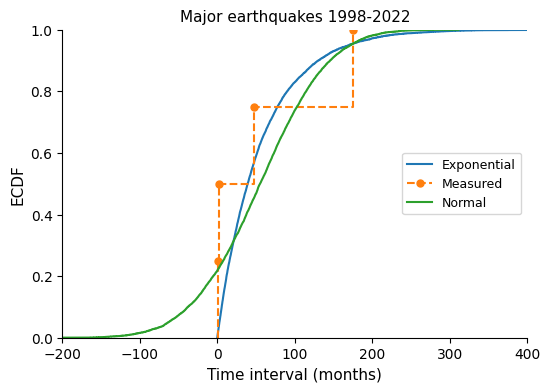

In [55]:
# Calculate time gaps between major tremors
time_gap_days = [quakes_major.index[i+1] - quakes_major.index[i] \
                 for i in range(len(quakes_major) - 1)]

# Convert into months
time_gap_months = np.array([time_gap_days[i].total_seconds() / (60 * 60 * 24 * 30) \
                            for i in range(len(time_gap_days))])

# Compute the mean time gap: mean_time_gap
mean_time_gap = np.mean(time_gap_months)
print(f"Rate -> {mean_time_gap:.0f} months")

# Standard deviation of the time gap
std_time_gap = np.std(time_gap_months)

# Generate theoretical Exponential distribution of timings
time_gap_exp = np.random.exponential(mean_time_gap, size=10000)

# Generate theoretical Normal distribution of timings
time_gap_norm = np.random.normal(mean_time_gap, std_time_gap, size=10000)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.ecdfplot(time_gap_exp, ax=ax, label="Exponential")
sns.ecdfplot(time_gap_months, ax=ax, marker=".", markersize=10, linestyle="--", label="Measured")
sns.ecdfplot(time_gap_norm, ax=ax, label="Normal")

ax.tick_params(axis='x', labelsize=10, rotation=0)
ax.tick_params(axis='y', labelsize=10)
ax.set_title("Major earthquakes 1998-2022", fontsize=11)
ax.set_xlabel("Time interval (months)", fontsize=11)
ax.set_ylabel("ECDF", fontsize=11)
ax.set_xlim(-200, 400)
ax.legend(loc='center right', fontsize=9)
sns.despine()

plt.show()

I would say the distribution model is closer to an exponential one than to a normal one.

In that case:
- When will it happen the next major earthquake in the region?

In [56]:
# Store today date
today = date.today()

# Store last major quake date
last_quake = quakes_major.index[-1].date()

# Months passed since last major quake
months_since_last_quake = (today - last_quake).total_seconds() / (60 * 60 * 24 * 30)

print(f"Today: {today}")
print(f"Last quake: {last_quake}")
print(f"-> {months_since_last_quake:.1f} months have passed since last major quake")

Today: 2023-03-17
Last quake: 2020-09-08
-> 30.7 months have passed since last major quake


In [57]:
# Draw samples from the Exponential distribution
exp_samples = np.random.exponential(mean_time_gap, size=100000)

# No earthquake as of today, so only keep samples that are long enough
exp_samples = exp_samples[exp_samples > months_since_last_quake]

# Compute the confidence intervals and median
conf_int_exp = np.percentile(exp_samples, [2.5, 50, 97.5])

# Calculate corresponding days
day_0025 = last_quake + timedelta(days=conf_int_exp[0] * 30)
day_0500 = last_quake + timedelta(days=conf_int_exp[1] * 30)
day_0975 = last_quake + timedelta(days=conf_int_exp[2] * 30)

# Print the results
print(f"Median: {conf_int_exp[1]:.0f} months --> {day_0500}")
print(f"95% ci: [{conf_int_exp[0]:.0f}, {conf_int_exp[2]:.0f}] \
months --> [{day_0025}, {day_0975}]")

Median: 70 months --> 2026-06-09
95% ci: [32, 239] months --> [2023-04-30, 2040-04-22]


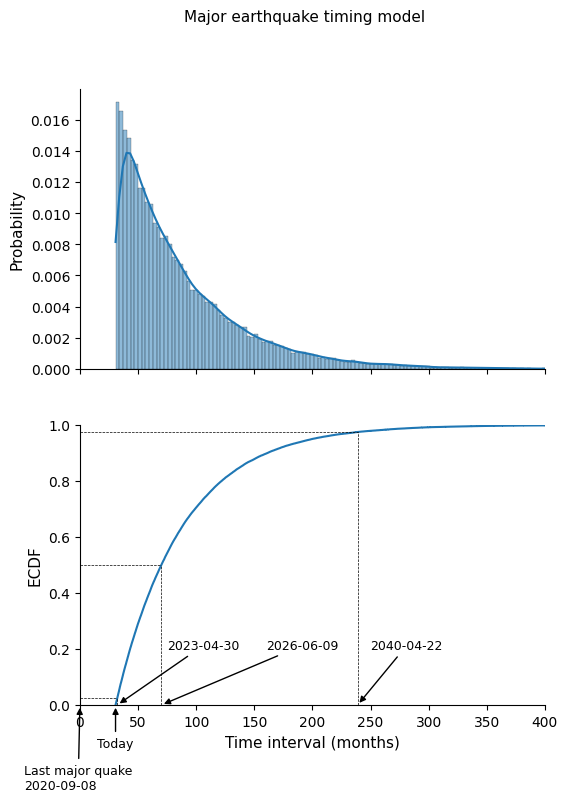

In [58]:
# Plot
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 8))

fig.suptitle(f'Major earthquake timing model', fontsize=11)

sns.histplot(exp_samples, ax=ax[0], stat="density", kde=True)
sns.ecdfplot(exp_samples, ax=ax[1])

for i in range(2):
    ax[i].tick_params(axis='x', labelsize=10, rotation=0)
    ax[i].tick_params(axis='y', labelsize=10)
    ax[i].set_xlabel("Time interval (months)", fontsize=11)
    ax[i].set_xlim(0, 400)
  
ax[0].set_ylabel("Probability", fontsize=11)
ax[1].set_ylabel("ECDF", fontsize=11)

ax[1].axvline(conf_int_exp[0], ymax=0.025, linestyle="--", color="black", linewidth=0.5)
ax[1].axvline(conf_int_exp[1], ymax=0.5, linestyle="--", color="black", linewidth=0.5)
ax[1].axvline(conf_int_exp[2], ymax=0.975, linestyle="--", color="black", linewidth=0.5)
ax[1].axhline(0.025, xmax=conf_int_exp[0] / 400, linestyle="--", color="black", linewidth=0.5)
ax[1].axhline(0.5, xmax=conf_int_exp[1] / 400, linestyle="--", color="black", linewidth=0.5)
ax[1].axhline(0.975, xmax=conf_int_exp[2] / 400, linestyle="--", color="black", linewidth=0.5)

ax[1].annotate("Last major quake\n2020-09-08",
            xy=(0, 0), 
            xytext=(-48, -0.3), fontsize=9,
            arrowprops={"arrowstyle":"-|>", "color":"black"})

ax[1].annotate("Today",
            xy=(months_since_last_quake, 0), 
            xytext=(15, -0.15), fontsize=9,
            arrowprops={"arrowstyle":"-|>", "color":"black"})

ax[1].annotate(day_0025,
            xy=(conf_int_exp[0], 0), 
            xytext=(75, 0.2), fontsize=9,
            arrowprops={"arrowstyle":"-|>", "color":"black"})

ax[1].annotate(day_0500,
            xy=(conf_int_exp[1], 0), 
            xytext=(160, 0.2), fontsize=9,
            arrowprops={"arrowstyle":"-|>", "color":"black"})

ax[1].annotate(day_0975,
            xy=(conf_int_exp[2], 0), 
            xytext=(250, 0.2), fontsize=9,
            arrowprops={"arrowstyle":"-|>", "color":"black"})

sns.despine()

plt.show()

So we can expect to have a major earthquake ("major" for the standards in this region: magnitude >= 3) somewhere between the dates that limit the 95% confidence interval in the probability distribution above.

## Conclusion
I thought that earthquakes were extremely rare in the region I live in, but in this little project I learnt that there is quite a seismic activity around, even if it is of very low magnitude. I confirmed that devastating quakes like the ones in Turkey and Syria are unlikely to happen here according to the data and the models used in seismology.

I will try to be watchful in the next few years: most probably at least a magnitude 3 earthquake will happen until 2040.   
And who knows, there is a 2% probability of the earthquake being higher than 4, and so clearly noticeable (and scaring).